In [24]:
# load the packages
import xarray as xr
import pandas as pd
import numpy  as np
from ipynb.fs.full.Untitled2 import save_netcdf
import os
import shutil

# station list
station_list = ["05HG001"] # coresponsing with 16th segment of network topology

# load the file that include the data
ds = xr.open_dataset('/Users/shg096/Desktop/HYDAT_05.nc') # direction to HYDAT_05 point
ds = ds.sel(time=slice('2013-06-01','2013-07-10'))
station_all = list (np.array(ds.Station_ID[:]))

# subseting the netcdf file
idx = [station_all.index(i) for i in station_list]
print(idx)
ds_subset = ds.isel(n=idx)

print(ds_subset)

ds = ds_subset.to_dataframe()

ds = ds.reset_index(level=1, drop=True)

ds = ds['Flow']

ds = pd.DataFrame(ds)

ds = ds.rename(columns={'0':'Flow'})

ds.to_csv('../data/observation_05HG001.csv')




[740]
<xarray.Dataset>
Dimensions:          (time: 40, n: 1)
Coordinates:
  * time             (time) datetime64[ns] 2013-06-01 2013-06-02 ... 2013-07-10
    lat              (n) float64 ...
    lon              (n) float64 ...
    Station_ID       (n) object ...
Dimensions without coordinates: n
Data variables:
    Flow             (n, time) float64 ...
    flags            (n, time) |S1 ...
    DrainageAreaEff  (n) float64 ...
    DrainageArea     (n) float64 ...
    Station_Name     (n) object ...
    ID               (n) int32 ...
Attributes:
    Conventions:  CF-1.6
    License:      The file is created by Shervan Gharari, under MIT, https://...
    history:      Created Fri Jul 12 22:04:01 2019
    source:       described 1418 gauges stating with code 05 of WSC HYDAT data


In [ ]:
ds = pd.read_csv('../data/observation_05HG001.csv')



In [59]:
import numpy as np
import os

path = './ancillary_data/'
file_name_tmp = 'param.nml.default.tmp'
file_name     = 'param.nml.default'

velocities    = np.arange(0.5,1.6,0.1)
diffusivities = np.arange(500,10500,500)
# velocities    = np.arange(0.5,0.7,0.1)
# diffusivities = np.arange(500,1500,500)
old_strings = ["velocity","diffusivity"]

params = None
for velocity in velocities:
    for diffusivity in diffusivities:
        if params is not None:
            params = np.append (params, np.array([[velocity,diffusivity]]),axis=0)
        else:
            params = np.array([[velocity,diffusivity]])

for row in params:
    V = "%.1f" % row[0]
    D = "%.0f" % row[1]
    case_name = 'V_'+V+'_D_'+D
    with open(path+file_name_tmp, "r+") as text_file:
        texts = text_file.read()
        for i in np.arange(len(old_strings)):
            texts = texts.replace(old_strings[i], str(row[i]))
    with open(path+case_name+'_'+file_name, "w") as text_file:
        text_file.write(texts)
        
    # update the case name in the setting file
    with open('./settings/HDMA_CLM5-runoff-lake.control.tmp', "r+") as text_file:
        texts = text_file.read()
        texts = texts.replace("CASENAME", case_name)
    with open('./settings/HDMA_CLM5-runoff-lake.control', "w") as text_file:
        text_file.write(texts)
        
    # execute the model
    os.system('./route_runoff.mpi-pio.exe ./settings/HDMA_CLM5-runoff-lake.control')
    

[  0.5 500. ]
0.5
500.0
V_0.5_D_500.0
[5.e-01 1.e+03]
0.5
1000.0
V_0.5_D_1000.0
[  0.6 500. ]
0.6
500.0
V_0.6_D_500.0
[6.e-01 1.e+03]
0.6
1000.0
V_0.6_D_1000.0


In [96]:
import xarray as xr
import glob
import pandas as pd
import os

file_names = sorted(glob.glob('./output/test/*.mizuRoute.h.2013-06-01-00000.nc'))

df = pd.DataFrame()

for file_name in file_names:
    ds = xr.open_dataset(file_name)
    base = os.path.basename(file_name)
    base = base.replace('.mizuRoute.h.2013-06-01-00000.nc','')
    print(base)
    df [base] = ds.IRFroutedRunoff[:,15]

df.to_csv('./output/calibration_output.csv')   


In [97]:
print(df)

Empty DataFrame
Columns: []
Index: []


            V_0.5_D_1000  V_0.5_D_10000  ...  V_1.5_D_9000  V_1.5_D_9500
2013-06-01     238.08992       2.063861  ...     238.10070     225.73802
2013-06-02     302.47025       4.785260  ...     302.47860     292.00120
2013-06-03     385.46610       5.443431  ...     385.47223     378.00864
2013-06-04     423.86798       4.465644  ...     423.87024     420.96204
2013-06-05     484.50146       3.203294  ...     484.50333     482.23730
2013-06-06     494.53170       2.170658  ...     494.53165     494.57834
2013-06-07     503.04446       1.423846  ...     503.04456     503.02454
2013-06-08     444.79648       0.914496  ...     444.79560     445.66565
2013-06-09     456.07782      24.145990  ...     456.07846     455.38834
2013-06-10     476.89005      85.575550  ...     476.89030     476.68167
2013-06-11     507.23930     170.876800  ...     507.23972     506.94670
2013-06-12     518.14420     258.669000  ...     518.14420     518.21650
2013-06-13     466.92093     328.813050  ...     46

Text(0, 0.5, 'Discharge at Saskatoon [m3/s]')

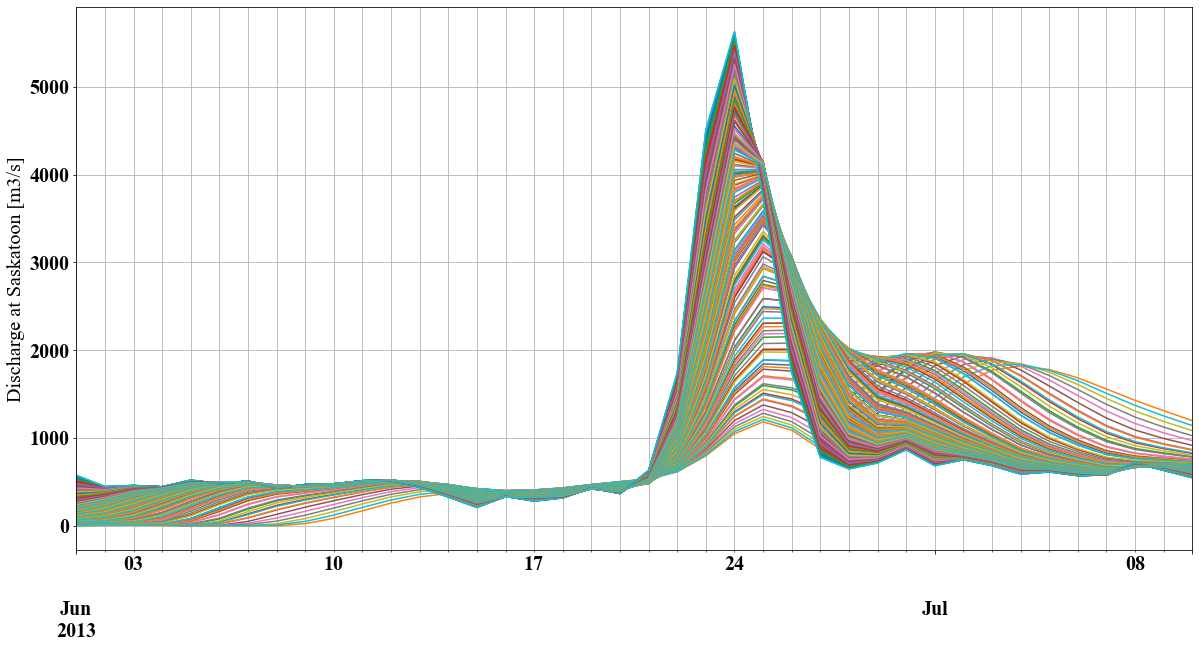

In [147]:
#import datetime #import date
import matplotlib.pyplot  as plt
import matplotlib
from ipynb.fs.full.Untitled2 import save_netcdf
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

df = pd.read_csv('/Users/shg096/Downloads/calibration_output.csv')

df = df.drop(columns=['Unnamed: 0'])
index = pd.date_range(start='2013-06-01', end='2013-07-10')
df = df.set_index(index)
# df = df.drop(columns=['Unnamed: 0'])

print(df)
print(len(df))
print(len(df.columns))

#
df.plot(figsize=(20,10))
plt.grid(which='both')
plt.gca().get_legend().remove()
plt.ylabel('Discharge at Saskatoon [m3/s]')


In [148]:
# load the packages
import xarray as xr
import pandas as pd
import numpy  as np
from ipynb.fs.full.Untitled2 import save_netcdf
import os
import shutil

# station list
station_list = ["05HG001"] # coresponsing with 16th segment of network topology

# load the file that include the data
ds = xr.open_dataset('/Users/shg096/Desktop/HYDAT_05.nc') # direction to HYDAT_05 point
ds = ds.sel(time=slice('2013-06-01','2013-07-10'))
station_all = list (np.array(ds.Station_ID[:]))

# subseting the netcdf file
idx = [station_all.index(i) for i in station_list]
print(idx)
ds_subset = ds.isel(n=idx)

print (ds_subset)

observation = np.array(ds_subset.Flow[:]).flatten()

print(observation)



[740]
<xarray.Dataset>
Dimensions:          (time: 40, n: 1)
Coordinates:
  * time             (time) datetime64[ns] 2013-06-01 2013-06-02 ... 2013-07-10
    lat              (n) float64 ...
    lon              (n) float64 ...
    Station_ID       (n) object ...
Dimensions without coordinates: n
Data variables:
    Flow             (n, time) float64 ...
    flags            (n, time) |S1 ...
    DrainageAreaEff  (n) float64 ...
    DrainageArea     (n) float64 ...
    Station_Name     (n) object ...
    ID               (n) int32 ...
Attributes:
    Conventions:  CF-1.6
    License:      The file is created by Shervan Gharari, under MIT, https://...
    history:      Created Fri Jul 12 22:04:01 2019
    source:       described 1418 gauges stating with code 05 of WSC HYDAT data
[ 356.  351.  323.  331.  382.  396.  405.  420.  424.  441.  440.  441.
  449.  458.  434.  370.  339.  360.  415.  423.  526.  833. 1420. 1960.
 2120. 2210. 2240. 2200. 2010. 1710. 1510. 1120. 1010.  748.  727

In [149]:
# create the observation maximume
df_observed = df.copy()

for column in df_observed.columns:
    df_observed[column] = observation
    
print(df_observed)
print(df)
    

            V_0.5_D_1000  V_0.5_D_10000  ...  V_1.5_D_9000  V_1.5_D_9500
2013-06-01         356.0          356.0  ...         356.0         356.0
2013-06-02         351.0          351.0  ...         351.0         351.0
2013-06-03         323.0          323.0  ...         323.0         323.0
2013-06-04         331.0          331.0  ...         331.0         331.0
2013-06-05         382.0          382.0  ...         382.0         382.0
2013-06-06         396.0          396.0  ...         396.0         396.0
2013-06-07         405.0          405.0  ...         405.0         405.0
2013-06-08         420.0          420.0  ...         420.0         420.0
2013-06-09         424.0          424.0  ...         424.0         424.0
2013-06-10         441.0          441.0  ...         441.0         441.0
2013-06-11         440.0          440.0  ...         440.0         440.0
2013-06-12         441.0          441.0  ...         441.0         441.0
2013-06-13         449.0          449.0  ...       

In [150]:
# claculate the objcetive function

# setting the first few rows as NaNa

df_observed[df_observed.index<'2013-06-15'] = None

print(df_observed)



            V_0.5_D_1000  V_0.5_D_10000  ...  V_1.5_D_9000  V_1.5_D_9500
2013-06-01           NaN            NaN  ...           NaN           NaN
2013-06-02           NaN            NaN  ...           NaN           NaN
2013-06-03           NaN            NaN  ...           NaN           NaN
2013-06-04           NaN            NaN  ...           NaN           NaN
2013-06-05           NaN            NaN  ...           NaN           NaN
2013-06-06           NaN            NaN  ...           NaN           NaN
2013-06-07           NaN            NaN  ...           NaN           NaN
2013-06-08           NaN            NaN  ...           NaN           NaN
2013-06-09           NaN            NaN  ...           NaN           NaN
2013-06-10           NaN            NaN  ...           NaN           NaN
2013-06-11           NaN            NaN  ...           NaN           NaN
2013-06-12           NaN            NaN  ...           NaN           NaN
2013-06-13           NaN            NaN  ...       

In [151]:
df_diff = df - df_observed

df_diff = abs(df_diff)

df_diff = df_diff.sum()

df_diff = df_diff.sort_values()

print(df_diff)


V_0.5_D_1000     12340.84082
V_0.5_D_10000    15896.41709
V_0.5_D_1500      9619.80297
V_0.5_D_2000      6908.57731
V_0.5_D_2500      4751.20094
                    ...     
V_1.5_D_7500     13229.55408
V_1.5_D_8000     12936.29587
V_1.5_D_8500     12638.75569
V_1.5_D_9000     12341.09315
V_1.5_D_9500     12038.40492
Length: 220, dtype: float64


In [166]:
import netCDF4 as nc4
dset = nc4.Dataset('/Users/shg096/Downloads//WM.nc')
print(list(dset.variables))
variables = list(dset.variables)

variables = [x for x in variables if x.startswith('Volume_')]

variables = sorted(variables)

for variable in variables:

    # update the case name in the setting file
    with open('./settings/HDMA_CLM5-runoff-lake.control.tmp', "r+") as text_file:
        texts = text_file.read()
        texts = texts.replace("CASENAME", variable)
    with open('./settings/HDMA_CLM5-runoff-lake.control', "w") as text_file:
        text_file.write(texts)
        
    # execute the model
    os.system('./route_runoff.mpi-pio.exe ./settings/HDMA_CLM5-runoff-lake.control')
        

['time', 'Volume_03_20_29', 'column_name', 'ID', 'Volume_02_20_29', 'Volume_16_15_27', 'Volume_16_19_30', 'Volume_17_15_27', 'Volume_17_19_30', 'Volume_16_14_29', 'Volume_17_14_29', 'Volume_14_16_30', 'Volume_15_16_30', 'Volume_19_20_27', 'Volume_20_19_29', 'Volume_18_20_27', 'Volume_11_14_26', 'Volume_10_14_26', 'Volume_11_15_28', 'Volume_10_15_28', 'Volume_20_18_27', 'Volume_04_20_26', 'Volume_20_14_30', 'Volume_05_20_26', 'Volume_01_16_28', 'Volume_00_16_28', 'Volume_01_17_26', 'Volume_00_17_26', 'Volume_19_19_26', 'Volume_20_20_28', 'Volume_04_18_29', 'Volume_18_19_26', 'Volume_05_18_29', 'Volume_04_15_30', 'Volume_19_18_28', 'Volume_04_19_27', 'Volume_18_18_28', 'Volume_05_15_30', 'Volume_05_19_27', 'Volume_06_17_29', 'Volume_07_17_29', 'Volume_06_16_27', 'Volume_07_16_27', 'Volume_03_19_28', 'Volume_02_19_28', 'Volume_03_18_26', 'Volume_02_18_26', 'Volume_06_18_30', 'Volume_06_14_27', 'Volume_07_18_30', 'Volume_07_14_27', 'Volume_13_20_27', 'Volume_12_20_27', 'Volume_06_15_29', '

FileNotFoundError: [Errno 2] No such file or directory: './settings/HDMA_CLM5-runoff-lake.control.tmp'

In [167]:
print(len(variables))

735


In [324]:
df = pd.read_csv('/Users/shg096/Downloads/final.csv')

df_max = df.max()

# df_max = df_max-2496.6729

df_max = df_max.drop(['Unnamed: 0'])

print(df_max)

vol_total = None
start_date = None
end_date = None

for index in df_max.index:
#     print(index)
    index_list = index.split('_')
    
#     print(index_list)
    
    if vol_total is None:
        vol_total = np.array(float(index_list[1]))
        start_date = np.array(int(index_list[2]))
        end_date = np.array(int(index_list[3]))
    else:
        vol_total = np.append(vol_total,float(index_list[1]))
        start_date = np.append(start_date,int(index_list[2]))
        end_date = np.append(end_date,int(index_list[3]))

print(df_max)

df_final = pd.DataFrame()
df_final['discharge'] = np.array(df_max)
df_final['init'] = vol_total
df_final['start'] = start_date
df_final['end'] = end_date

print(df_final)
    



Volume_00_14_26    2496.6729
Volume_00_14_27    2496.6729
Volume_00_14_28    2496.6729
Volume_00_14_29    2496.6729
Volume_00_14_30    2496.6729
                     ...    
Volume_20_20_26    1606.9940
Volume_20_20_27    1436.4912
Volume_20_20_28    1495.5641
Volume_20_20_29    1613.1660
Volume_20_20_30    1696.7494
Length: 735, dtype: float64
Volume_00_14_26    2496.6729
Volume_00_14_27    2496.6729
Volume_00_14_28    2496.6729
Volume_00_14_29    2496.6729
Volume_00_14_30    2496.6729
                     ...    
Volume_20_20_26    1606.9940
Volume_20_20_27    1436.4912
Volume_20_20_28    1495.5641
Volume_20_20_29    1613.1660
Volume_20_20_30    1696.7494
Length: 735, dtype: float64
     discharge  init  start  end
0    2496.6729   0.0     14   26
1    2496.6729   0.0     14   27
2    2496.6729   0.0     14   28
3    2496.6729   0.0     14   29
4    2496.6729   0.0     14   30
..         ...   ...    ...  ...
730  1606.9940  20.0     20   26
731  1436.4912  20.0     20   27
732  1495

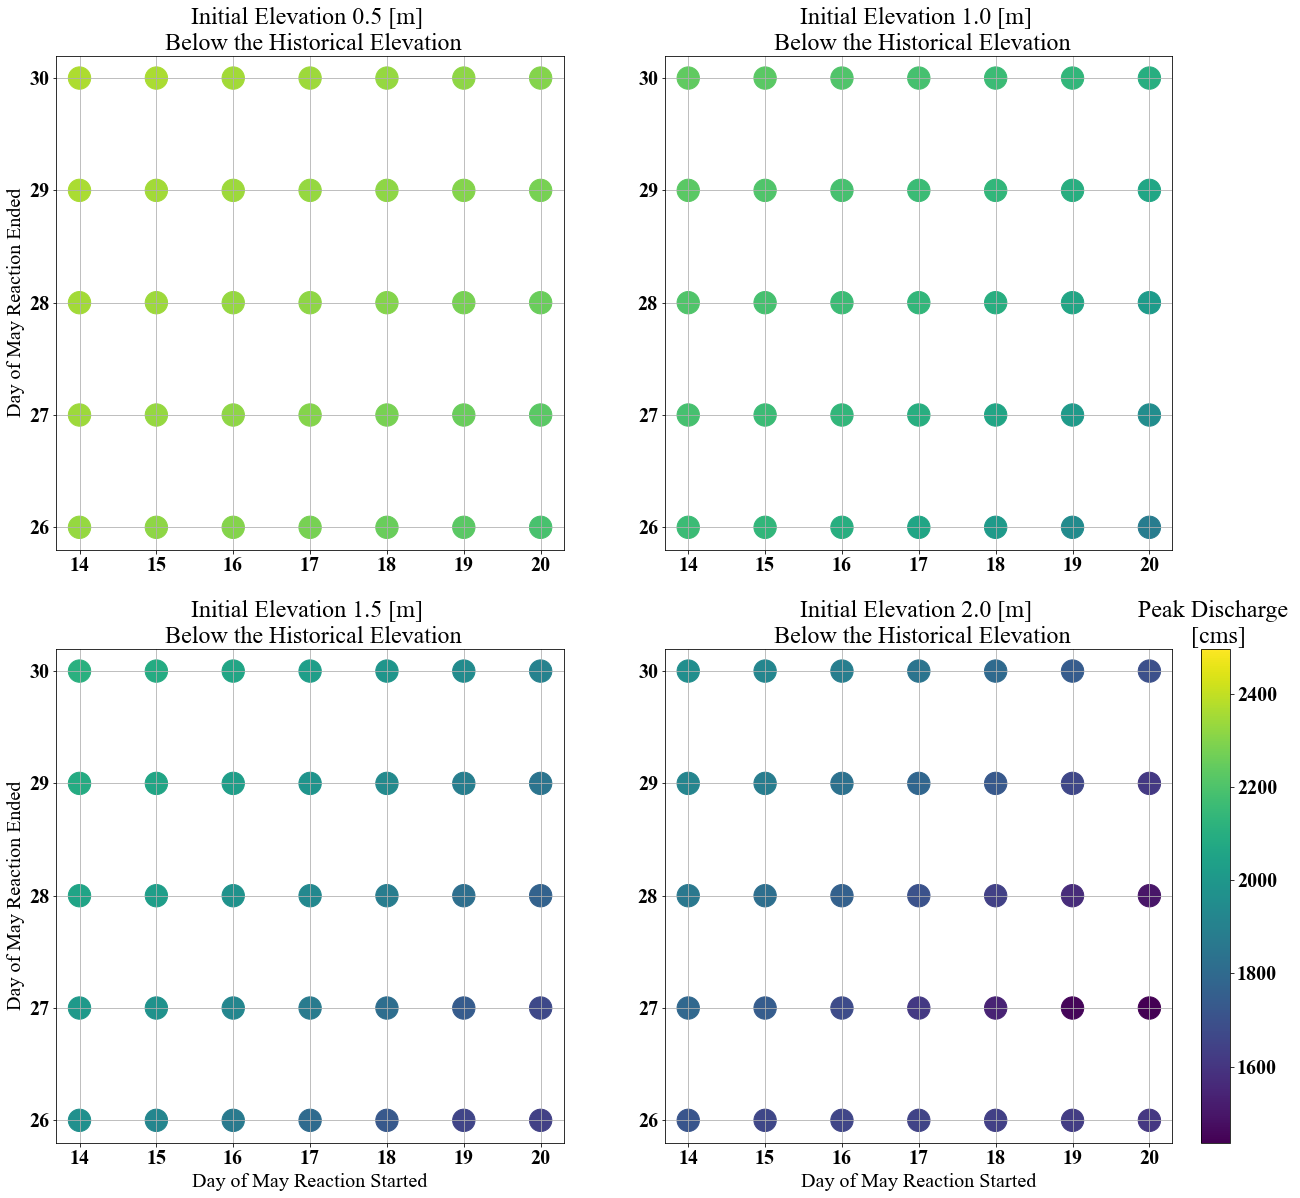

In [326]:
from matplotlib.ticker import MaxNLocator
#...



fig, axs = plt.subplots(2, 2, figsize=(20, 20)) # 


depth = np.array([5,10,15,20])
m = 0

for i in np.arange(2):
    for j in np.arange(2):

        #
        df_final_slice = df_final[df_final['init']==depth[m]]
        A = axs[i,j].scatter(df_final_slice.start, df_final_slice.end,
                             c=df_final_slice.discharge,
                             vmin = df_final['discharge'].min(),
                             vmax = df_final['discharge'].max(),
                             s=500)
        axs[i,j].grid()
        axs[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i,j].set_title('Initial Elevation '+ str(depth[m]/10) + ' [m] \n Below the Historical Elevation')
        if j == 0 :
            axs[i,j].set_ylabel('Day of May Reaction Ended')
        if i == 1 :
            axs[i,j].set_xlabel('Day of May Reaction Started')
        
        m = m + 1

# A.colorbar()

pos2 = axs[1, 1].get_position()

cb_ax = fig.add_axes([pos2.x1+0.02, pos2.y0, 0.02, pos2.y1-pos2.y0])
cbar  = fig.colorbar(A, cax=cb_ax)

cbar.ax.set_title('Peak Discharge \n [cms]')

plt.savefig('../fig/Max_discharge_Saskatoon_2D.png',dpi=200)





In [321]:
df = pd.read_csv('/Users/shg096/Downloads/final.csv')

df_max = df.max()

df_max = df_max-2496.6729

df_max = df_max.drop(['Unnamed: 0'])

print(df_max)

vol_total = None
start_date = None
end_date = None

for index in df_max.index:
#     print(index)
    index_list = index.split('_')
    
#     print(index_list)
    
    if vol_total is None:
        vol_total = np.array(float(index_list[1]))
        start_date = np.array(int(index_list[2]))
        end_date = np.array(int(index_list[3]))
    else:
        vol_total = np.append(vol_total,float(index_list[1]))
        start_date = np.append(start_date,int(index_list[2]))
        end_date = np.append(end_date,int(index_list[3]))

print(df_max)

df_final = pd.DataFrame()
df_final['discharge'] = np.array(df_max)
df_final['init'] = vol_total
df_final['start'] = start_date
df_final['end'] = end_date

print(df_final)

    

Volume_00_14_26       0.0000
Volume_00_14_27       0.0000
Volume_00_14_28       0.0000
Volume_00_14_29       0.0000
Volume_00_14_30       0.0000
                     ...    
Volume_20_20_26    -889.6789
Volume_20_20_27   -1060.1817
Volume_20_20_28   -1001.1088
Volume_20_20_29    -883.5069
Volume_20_20_30    -799.9235
Length: 735, dtype: float64
Volume_00_14_26       0.0000
Volume_00_14_27       0.0000
Volume_00_14_28       0.0000
Volume_00_14_29       0.0000
Volume_00_14_30       0.0000
                     ...    
Volume_20_20_26    -889.6789
Volume_20_20_27   -1060.1817
Volume_20_20_28   -1001.1088
Volume_20_20_29    -883.5069
Volume_20_20_30    -799.9235
Length: 735, dtype: float64
     discharge  init  start  end
0       0.0000   0.0     14   26
1       0.0000   0.0     14   27
2       0.0000   0.0     14   28
3       0.0000   0.0     14   29
4       0.0000   0.0     14   30
..         ...   ...    ...  ...
730  -889.6789  20.0     20   26
731 -1060.1817  20.0     20   27
732 -1001

Text(0.5, 1.0, 'Peak Discharge \n [cms]')

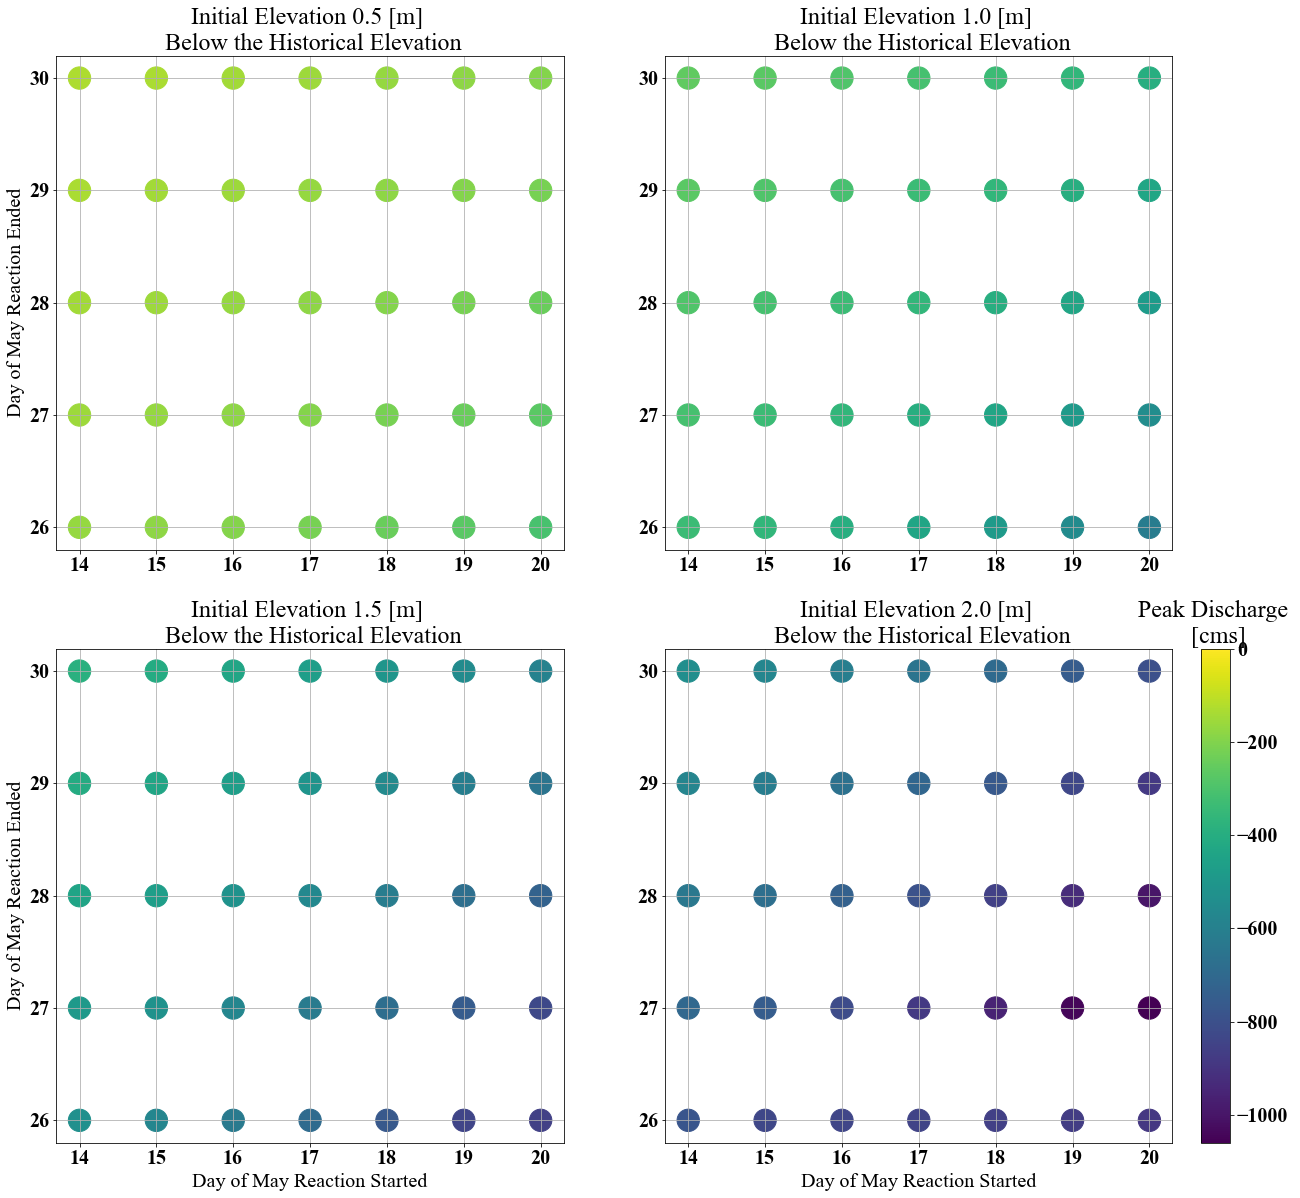

In [322]:
from matplotlib.ticker import MaxNLocator
#...



fig, axs = plt.subplots(2, 2, figsize=(20, 20)) # 


depth = np.array([5,10,15,20])
m = 0

for i in np.arange(2):
    for j in np.arange(2):

        #
        df_final_slice = df_final[df_final['init']==depth[m]]
        A = axs[i,j].scatter(df_final_slice.start, df_final_slice.end,
                             c=df_final_slice.discharge,
                             vmin = df_final['discharge'].min(),
                             vmax = df_final['discharge'].max(),
                             s=500)
        axs[i,j].grid()
        axs[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i,j].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i,j].set_title('Initial Elevation '+ str(depth[m]/10) + ' [m] \n Below the Historical Elevation')
        if j == 0 :
            axs[i,j].set_ylabel('Day of May Reaction Ended')
        if i == 1 :
            axs[i,j].set_xlabel('Day of May Reaction Started')
        
        m = m + 1

# A.colorbar()

pos2 = axs[1, 1].get_position()

cb_ax = fig.add_axes([pos2.x1+0.02, pos2.y0, 0.02, pos2.y1-pos2.y0])
cbar  = fig.colorbar(A, cax=cb_ax)

cbar.ax.set_title('Peak Discharge \n [cms]')



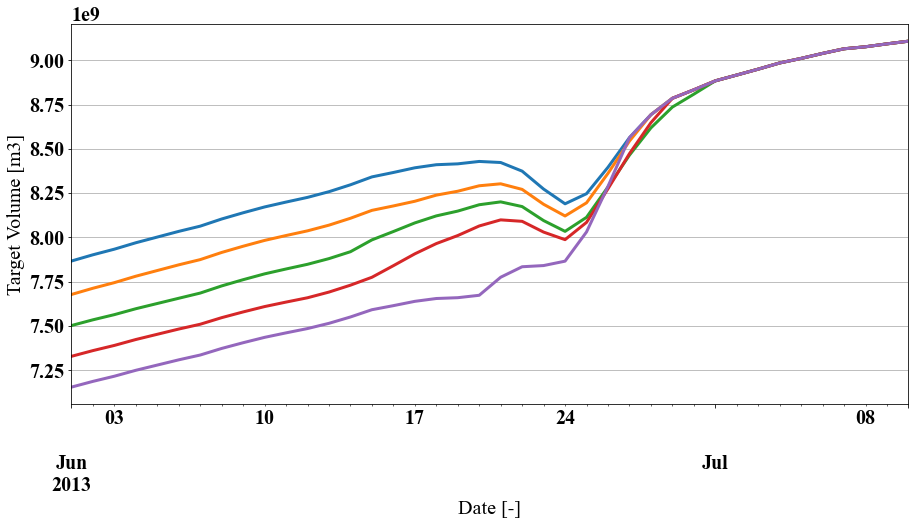

In [352]:

df_1  = pd.read_csv('../data/target_storage/Scenario_00_14_28.csv')

df_2  = pd.read_csv('../data/target_storage/Scenario_05_17_27.csv')

df_3  = pd.read_csv('../data/target_storage/Scenario_10_14_30.csv')

df_4  = pd.read_csv('../data/target_storage/Scenario_15_15_28.csv')

df_5  = pd.read_csv('../data/target_storage/Scenario_20_20_26.csv')

df_1['Datetime'] = pd.to_datetime(df_1['Unnamed: 0'])
df_1 = df_1.set_index('Datetime')

df_2['Datetime'] = pd.to_datetime(df_2['Unnamed: 0'])
df_2 = df_2.set_index('Datetime')

df_3['Datetime'] = pd.to_datetime(df_3['Unnamed: 0'])
df_3 = df_3.set_index('Datetime')

df_4['Datetime'] = pd.to_datetime(df_4['Unnamed: 0'])
df_4 = df_4.set_index('Datetime')

df_5['Datetime'] = pd.to_datetime(df_5['Unnamed: 0'])
df_5 = df_5.set_index('Datetime')



df_1['R13'].plot(figsize=(15,7),lw=3)
df_2['R13'].plot(figsize=(15,7),lw=3)
df_3['R13'].plot(figsize=(15,7),lw=3)
df_4['R13'].plot(figsize=(15,7),lw=3)
df_5['R13'].plot(figsize=(15,7),lw=3)


plt.grid(axis='y')
plt.xlabel('Date [-]')
plt.ylabel('Target Volume [m3]')

plt.savefig('../fig/sample_scenarios.png',dpi=200)
